In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [9]:
df = pd.read_csv('train10K.csv')
df = df[df['amount'] >0]

train_set, test_set = train_test_split(df, test_size=0.15, random_state=42)

y_train = train_set[["amount"]].copy()
X_train = train_set.drop(["approved","amount","label"],axis=1)
X_train = X_train.values.astype(np.float32)
y_train = y_train.values.reshape(-1)

y_test = test_set[["amount"]].copy()
y_test = y_test.values.reshape(-1)
X_test = test_set.drop(["approved","amount","label"],axis=1)
X_test = X_test.values.astype(np.float32)

X_valid, X_train = X_train[:1000], X_train[1000:]
y_valid, y_train = y_train[:1000], y_train[1000:]

In [17]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y = encoder.transform(y_train)
dummy_y = np_utils.to_categorical(encoded_y)

In [10]:
y_train

array([ 12000.,   2900.,   2100., ...,   3600.,   7900.,   3900.])

In [3]:
def clf_model():
    model = Sequential()
    model.add(Dense(100, input_dim=8, kernel_initializer='normal',activation='relu'))
    model.add(Dense(50,kernel_initializer='normal',activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
def regression_model():
    model = Sequential()
    
    model.add(Dense(100, input_dim=8, kernel_initializer='normal',activation='relu'))
    model.add(Dense(50,kernel_initializer='normal',activation='relu'))
    model.add(Dense(1,activation='linear',kernel_initializer='normal'))
    
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [5]:
seed = 7
np.random.seed(seed)
estimator = KerasRegressor(build_fn=clf_model,epochs=50,batch_size=50,verbose=0)

In [6]:
kfold = KFold(n_splits=5, random_state=seed)
result = cross_val_score(estimator,X_train,y_train,cv=kfold)
scores = np.sqrt(-result)

In [7]:
def score_show(scores):
    print("Score: ",scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

In [9]:
score_show(result)

Score:  [-0.02920458 -0.00394147 -0.00739842 -0.00449282 -0.00421797]
Mean:  -0.00985105163427
Standard Deviation:  0.00975643138532


In [12]:
model = regression_model()
history = model.fit(X_train, y_train, epochs=300,batch_size=50,validation_split=0.2)

Train on 3249 samples, validate on 813 samples
Epoch 1/300
3249/3249 [==============================] - 0s 75us/step - loss: 6560.2254 - val_loss: 6452.2011
Epoch 2/300
3249/3249 [==============================] - 0s 17us/step - loss: 6347.2644 - val_loss: 5959.5129
Epoch 3/300
3249/3249 [==============================] - 0s 16us/step - loss: 5385.0616 - val_loss: 4641.6412
Epoch 4/300
3249/3249 [==============================] - 0s 16us/step - loss: 4408.0104 - val_loss: 4169.8778
Epoch 5/300
3249/3249 [==============================] - 0s 14us/step - loss: 4170.5368 - val_loss: 4091.3231
Epoch 6/300
3249/3249 [==============================] - 0s 15us/step - loss: 4112.7357 - val_loss: 4081.3138
Epoch 7/300
3249/3249 [==============================] - 0s 15us/step - loss: 4097.4240 - val_loss: 4070.9023
Epoch 8/300
3249/3249 [==============================] - 0s 14us/step - loss: 4087.4843 - val_loss: 4060.9128
Epoch 9/300
3249/3249 [==============================] - 0s 14us/step - l

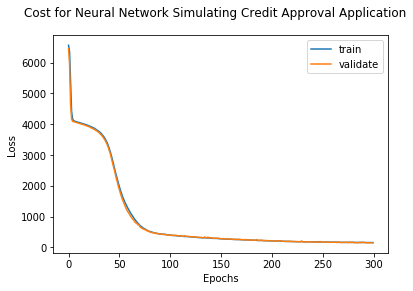

In [13]:
fig = plt.figure()
fig.suptitle('Cost for Neural Network Simulating Credit Approval Application')
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validate')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('cont.jpg')
plt.show()

In [15]:
model.evaluate(X_train,y_train)

4062/4062 [==============================] - 0s 17us/step


155.87774464369173

In [ ]:
y_pred = model.predict(X_valid[:100]) > 0.5
print(y_pred)

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_valid[:100], y_pred)

array([[36,  0],
       [ 0, 64]])

In [ ]:
y_valid

In [28]:
y_pred

array([[ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False]], dtype=bool)

In [14]:
def credit_approval_bug(citizen,state,age,sex,region,income_class,no_depend,marital):
    approved = 0
    amount = 0
    if (region == 5 or region == 6):
        amount = 0
    else:
        if (age < 18): ### BUG
            amount = 0
        else:
            if (citizen == 0):
                amount = 5000 + 1000*income_class
                if state == 0:
                    if (region == 3 or region == 4):
                        amount = amount*2.00
                    else:
                        amount = amount*1.50
                else:
                    amount = amount*1.10
                if (marital == 0):
                    if (no_depend > 0):
                        amount += 200*no_depend
                    else:
                        amount += 500
                else:
                    amount += 1000
                if (sex == 1): ##BUG
                    amount += 500
                else:
                    amount += 1000
            else:
                amount = 1000 + 800*income_class
                if (marital == 0):
                    if (no_depend > 2):
                        amount += 100*no_depend
                    else:
                        amount += 100
                else:
                    amount += 300
                if (sex == 1): #BUG
                    amount += 100
                else:
                    amount += 200
    if amount == 0:
        approved = 0
    else:
        approved = 1
    return approved, amount 